# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve, Statistics, Classes

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
# comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

In [3]:
# pip install networkx
# pip install nbconvert

### Roie Larger Network

In [4]:
## Prelims - sizes etc.

# NGrid = 7  # lattice dimansion is Ngrid X Ngrid 
# input_output_pairs = np.array([[204, 184], 
#                                [44, 64]])
# NGrid = 10  # lattice dimansion is Ngrid X Ngrid 
# input_output_pairs = np.array([[59, 94], 
#                                [444, 409]])
# NGrid = 20  # lattice dimansion is Ngrid X Ngrid
# input_output_pairs = np.array([[(NGrid+2)*5-1, (NGrid*(NGrid-2)+2)*5-1], 
#                               [(NGrid*(NGrid-1)-1)*5-1, (2*NGrid-1)*5-1]])

NGrid = 20  # lattice dimansion is Ngrid X Ngrid
row = 4  # row (and column) of input and output nodes in the NGrid X NGrid cell array
input_output_pairs = np.array([[(row*NGrid+(row+1))*5-1, (NGrid*(NGrid-(row+1))+(row+1))*5-1], 
                              [(NGrid*(NGrid-row)-row)*5-1, ((row+1)*NGrid-row)*5-1]])
print(input_output_pairs)

Periodic = False  # flag for lattice periodicity
net_typ = 'Cells'
K_max = 1
K_min = 0.05
u_thresh = 1
# input_p = arange(0.1, 7, 0.16)
# input_p = np.logspace(1.5, 5.5, num=120, base=10)
input_p = np.array([63])
# input_p = np.array([7, 70, 700, 1700, 17000])
# input_p = np.array([700])
for i in input_p:
    print(i)
flow_scheme = 'unidir'  # apply pressure drop only in the regular direction - constrained node = positive, ground = 0
# flow_scheme = 'taktak'  # apply pressure drop unidir once, then switch ground and constrained nodes to apply oposite dir.
iterations = 30

Variabs = Classes.User_variables(NGrid, Periodic, net_typ, K_max, K_min, u_thresh, input_p, 
                                     flow_scheme, iterations, input_output_pairs)

[[ 424 1524]
 [1579  479]]
63


In [5]:
## Build Incidence Matrices and vectors of edges


Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)

In [6]:
## Initiate Network state and K matrix

State = Classes.Net_state()
State.initiateK(Variabs, Strctr)

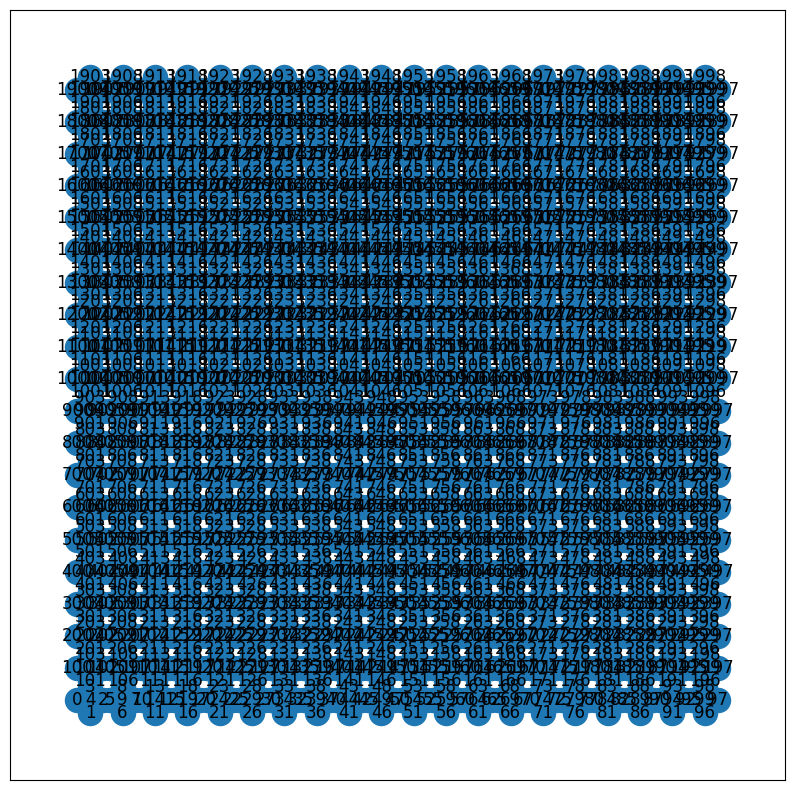

NET is ready


In [7]:
## build network and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(Strctr)
NET.build_pos_lattice(Variabs)

In [8]:
# input_output_pairs = np.array([[(NGrid+2)*5-1, (NGrid*(NGrid-2)+2)*5-1], 
#                               [(NGrid*(NGrid-1)-1)*5-1, (2*NGrid-1)*5-1]])

# input_output_pairs = np.array([[(2*NGrid+3)*5-1, (NGrid*(NGrid-3)+3)*5-1], 
#                               [(NGrid*(NGrid-2)-2)*5-1, (3*NGrid-2)*5-1]])

# row = 2
# input_output_pairs = np.array([[(row*NGrid+(row+1))*5-1, (NGrid*(NGrid-(row+1))+(row+1))*5-1], 
#                               [(NGrid*(NGrid-row)-row)*5-1, ((row+1)*NGrid-row)*5-1]])

# print(input_output_pairs)

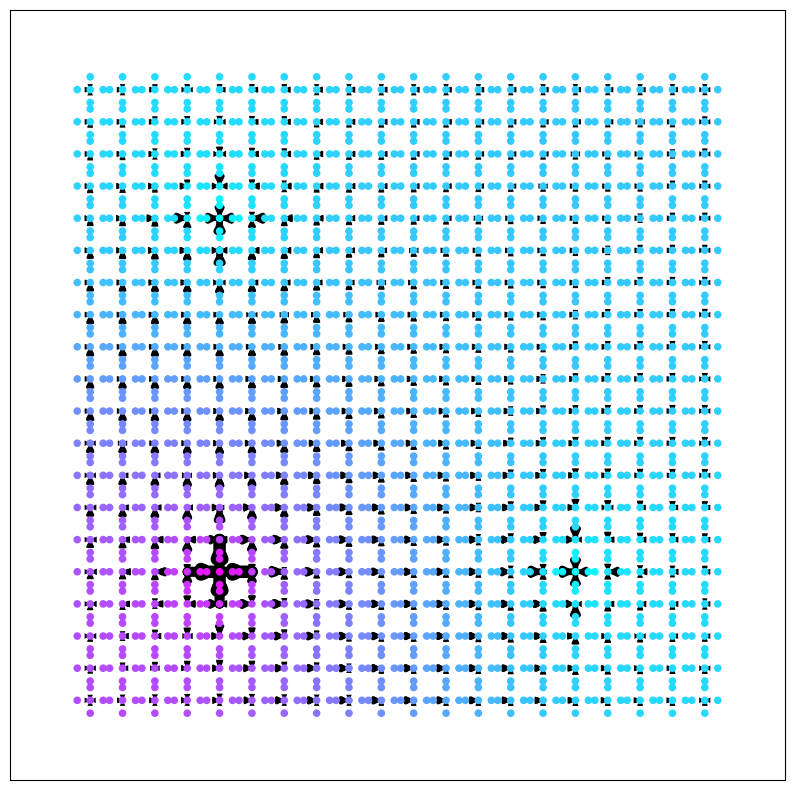

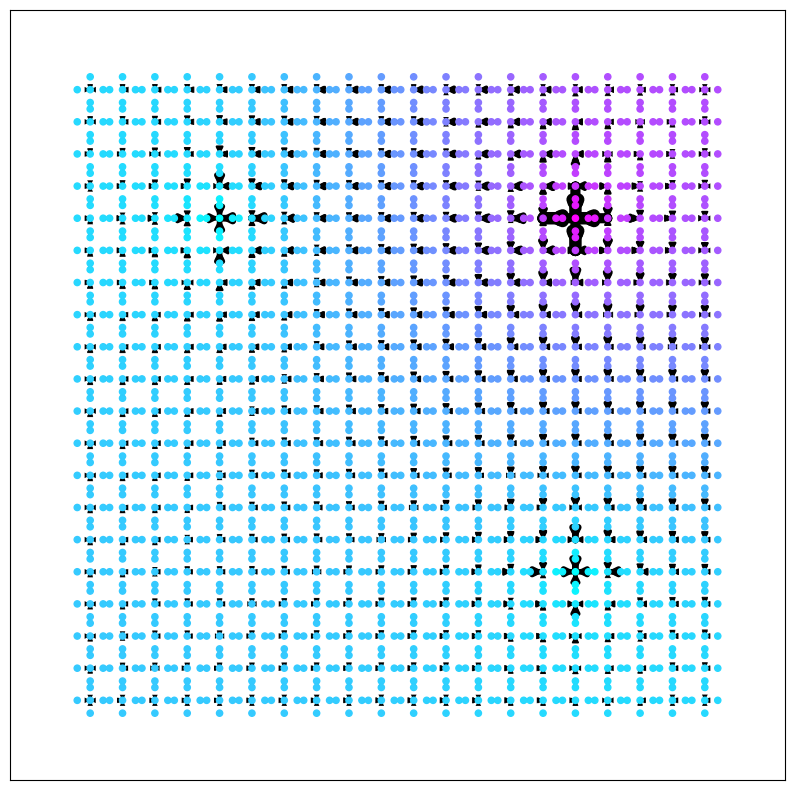

In [9]:
# flow with no marbles

p = 1  # dummy pressure

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(Variabs)
    
# save variables into class
Variabs.assign_input_p(p)

# Set up constraints for whole loop
Strctr.Setup_constraints(Variabs)

# Initiate K matrix again, not mandatory, better not doing it actually
State.initiateK(Variabs, Strctr)

# Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#        change constraints and repeat
State.flow_iterate(Variabs, Strctr, NET, 'no marbles', 'yes')

In [10]:
State.u_final

array([[0.2226899, 0.2226899],
       [0.2226899, 0.2226899]])

In [11]:
# # print(State.u_final)

# M = np.array([[[-1,1],[1,-1]],  [[1,-1],[-1,1]], [[1,1],[1,1]]])

# for i in range(3):
#     eigval, eigvec = la.eig(M[i,:,:])
#     print(eigval)
#     print(eigvec)

#     origin = np.array([[0, 0],[0, 0]]) # origin point
#     plt.quiver(*origin, eigvec[:,0], eigvec[:,1], color=['r','b','g'])
#     plt.show()
    
# eigval, eigvec = la.eig(np.array([[-0.01191728,  0.00644729], [ 0.01420359, -0.0087336 ]]))
# print(eigval)
# print(eigvec)

# origin = np.array([[0, 0],[0, 0]]) # origin point
# plt.quiver(*origin, eigvec[:,0], eigvec[:,1], color=['r','b','g'])
# plt.show()

### Main part - loop

In [12]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(input_p)])
convergence_time_vec = np.zeros([len(input_p), ])
# theta_vec = np.zeros([len(input_p), ])
shear_vec = np.zeros([len(input_p), ])  # 
u_allostery_arr = np.zeros([2, 2, len(input_p)])  # 

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(Variabs)

origin = np.array([[0, 0],[0, 0]]) # origin point

for i, p in enumerate(input_p):
    
    print(str(i*100/len(input_p)) + '% done')
    
    # save variables into class
    Variabs.assign_input_p(p)
    
    # Set up constraints for whole loop
    Strctr.Setup_constraints(Variabs)
    
    # Initiate K matrix again, not mandatory, better not doing it actually
    State.initiateK(Variabs, Strctr)
    
    # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
    #        change constraints and repeat
    State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
    MSE_arr[:, i] = State.MSE
    Hamming_arr[:, i] = State.Hamming
    # print(State.power_dissip)
    power_dissip_arr[:, i] = State.power_dissip
    convergence_time_vec[i] = State.convergence_time
    
    State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'no')
    print(State.u_final)
    
#     Variabs.iterations = 1
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
#     Variabs.iterations = 2
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
#     Variabs.iterations = 3
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
#     print(State.u_final)
    
#     Variabs.iterations = iterations
    
    u_allostery_arr[:,:, i] = State.u_final
    shear_vec[i] = Statistics.shear_type(State.u_final)
    
#     print(State.u_final-np.mean(np.mean(State.u_final), axis=0))
#     print(State.u_final)
#     eigval, eigvec = la.eig(State.u_final)
# #     print(eigval)
# #     print(eigvec)
#     theta_vec[i] = np.abs(np.arctan(eigvec[0,1]/eigvec[0,0])*180/np.pi)
# #     plt.quiver(*origin, eigvec[:,0], eigvec[:,1], color=['r','b','g'])
# #     plt.show()
    
    # print(State.u_final-np.mean(State.u_final, axis=0))

convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

0.0% done
loop break
[[2.67615334 5.26276794]
 [4.89754827 2.79999869]]


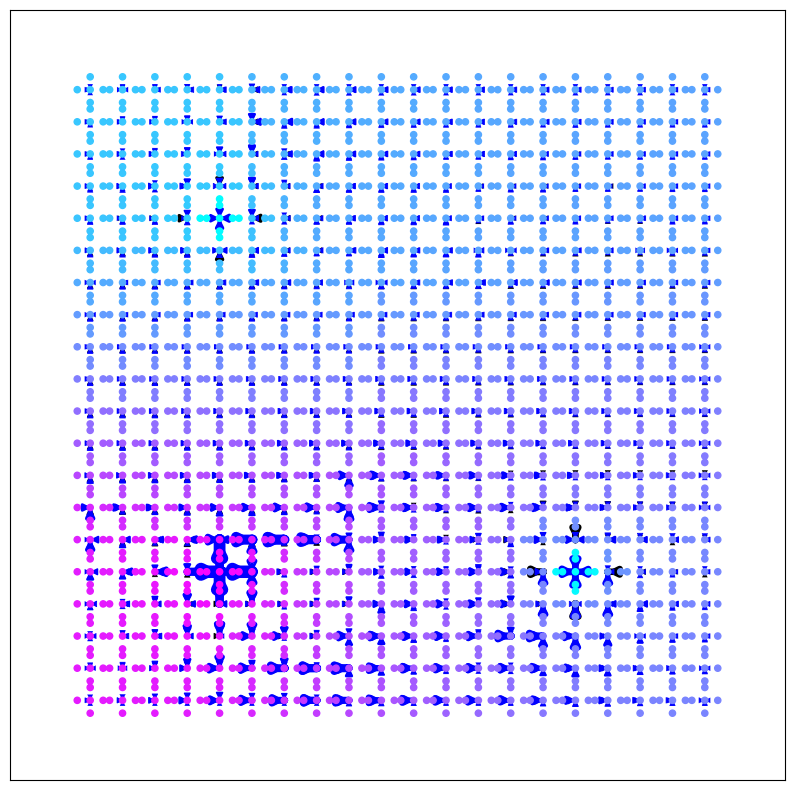

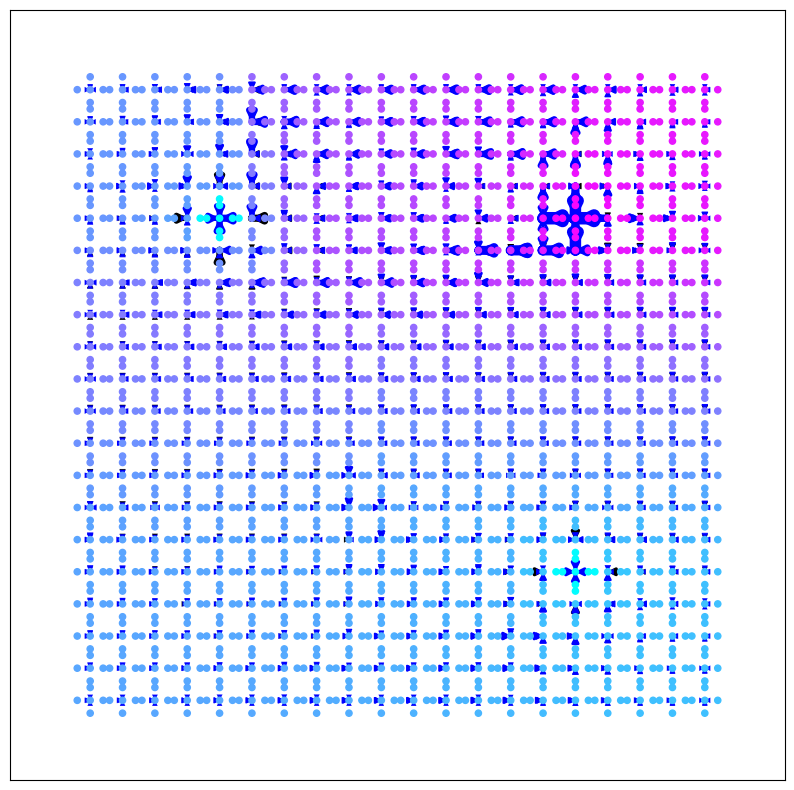

In [13]:
State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')

In [14]:
for j in State.K:
    print(j)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.05
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.05
1.0
1.0
1.0
0.05
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1

In [15]:
shear_vec[9]
input_p[9]

IndexError: index 9 is out of bounds for axis 0 with size 1

2024_02_10_18_07_03


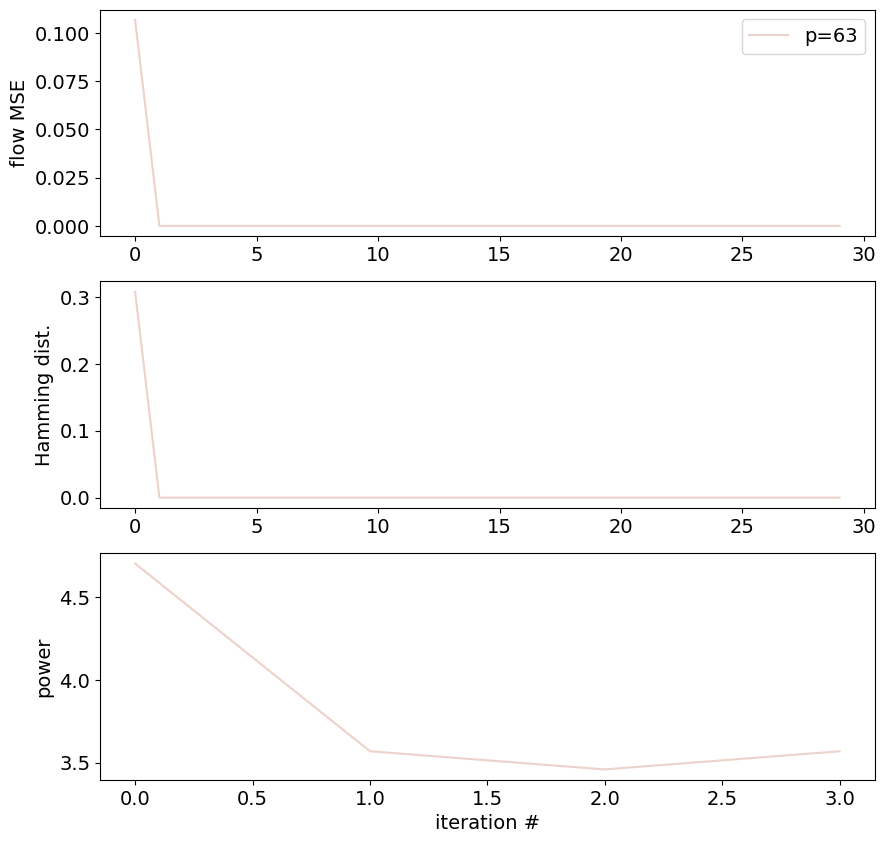

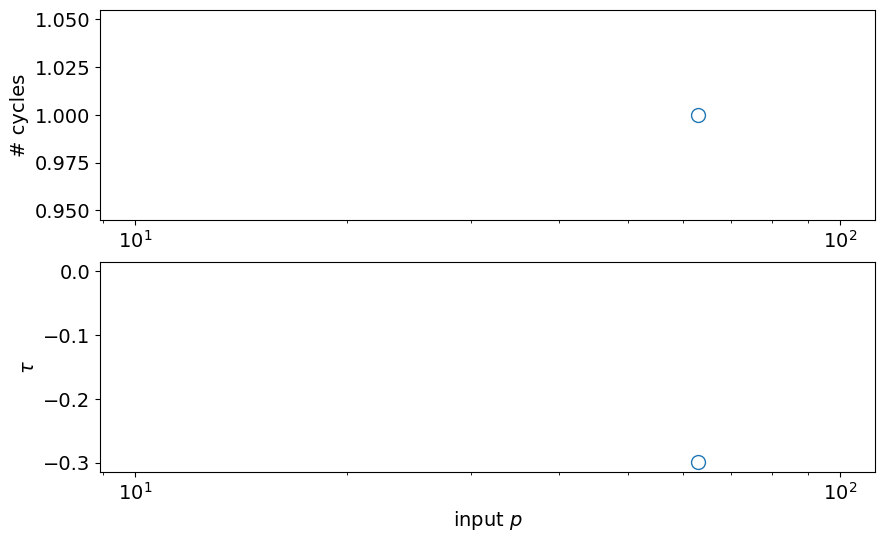

In [16]:
fig1, axes1 = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# cmap = plt.get_cmap('cool')
cmap = sns.cubehelix_palette(as_cmap=True)
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
legend_every = 10

for i, color in enumerate(colors, start=0):
    if i % legend_every == 0:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='p='+str(input_p[i]))
    else:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
    axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
    axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[i], color=color)
axes1[0].legend()
# plt.show()
axes1[2].set_xlabel('iteration #')
axes1[0].set_ylabel('flow MSE')
axes1[1].set_ylabel('Hamming dist.')
axes1[2].set_ylabel('power')

fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
axes2[0].semilogx(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
axes2[0].set_ylabel('# cycles')
# axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\theta$')
axes2[1].semilogx(input_p, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
axes2[1].semilogx(input_p, np.zeros([len(input_p),]))
axes2[1].set_xlabel('input $p$')
axes2[1].set_ylabel('$\\tau$')

## Save last figure as PNG with proper time
datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)
plt.savefig(comp_path + 'numCycles_and_tau_afo_p_'+str(datenow )+'.png')

# fig2 = plt.figure(figsize = (10,4))
# plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# plt.xlabel('input $p$')
# plt.ylabel('# cycles')
# # plt.legend(loc='upper right')
# plt.legend()

# plt.show()

# fig3 = plt.figure(figsize = (10,4))
# plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# plt.xlabel('input $p$')
# plt.ylabel('$\\theta$')
# # plt.legend(loc='upper right')
# plt.legend()

In [17]:
# Save inportant data as CSV

# import pandas as pd 

datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# df1 = pd.DataFrame(u_allostery_arr)
# print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
df2 = pd.DataFrame(np.array([input_p, shear_vec]))
df2.to_csv(comp_path + str(datenow) + "_shear_vec.csv")

2024_02_10_18_07_23


In [ ]:
print(convergence_time_vec)

In [ ]:
## Background flow - all outputs open, each input

State.flow_iterate(Variabs, Strctr, NET, 'no marbles', 'no')

u_final_noCond = State.u_final
print(u_final_noCond)

In [ ]:
## Initiate K matrix again, not mandatory, better not doing it actually

State.initiateK(Variabs, Strctr)

In [ ]:
## Loop - Pose constraints, build constraints matrix, solve flow and update conductances until convergence,
##        change constraints and repeat

State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')               

In [ ]:
if Variabs.flow_scheme == 'taktak':
    MSE = Statistics.flow_MSE(State.u_all, 4)
    Hamming = Statistics.K_Hamming(State.K_cells, 4)
elif Variabs.flow_scheme == 'unidir':
    MSE = Statistics.flow_MSE(State.u_all, 2)
    Hamming = Statistics.K_Hamming(State.K_cells, 2)
print(MSE)
print(Hamming)

plt.plot(MSE)
plt.show()

plt.plot(Hamming)
plt.show()

In [ ]:
## Allostery Test

State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')  

In [ ]:
u_final_cond = State.u_final

print('pushing from ' + str(Strctr.Nodes_full[0]))
print('out of edge ' + str(Strctr.GroundNodes_full[0]) + ' flows ' + str(u_final_Cond[0,0]))
print('and out of edge ' + str(Strctr.GroundNodes_full[1]) + ' flows ' + str(u_final_Cond[0,1]))
print('pushing from ' + str(Strctr.Nodes_full[1]))
print('out of edge ' + str(Strctr.GroundNodes_full[0]) + ' flows ' + str(u_final_Cond[1,0]))
print('and out of edge ' + str(Strctr.GroundNodes_full[1]) + ' flows ' + str(u_final_Cond[1,1]))

In [ ]:
u_final_norm = u_final_cond/u_final_noCond
print(u_final_cond)
print(u_final_noCond)

print(u_final_norm)

for i in range(2):
    print('for node ' + str(Strctr.Nodes_full[i][0]) + ' the lower velocity is at ' + 
          str(Strctr.GroundNodes_full[np.where(u_final_norm[:,i] == min(u_final_norm[:,i]))[0][0]]))

### Roie Very Simple Net

A net of a single cross 

<div>
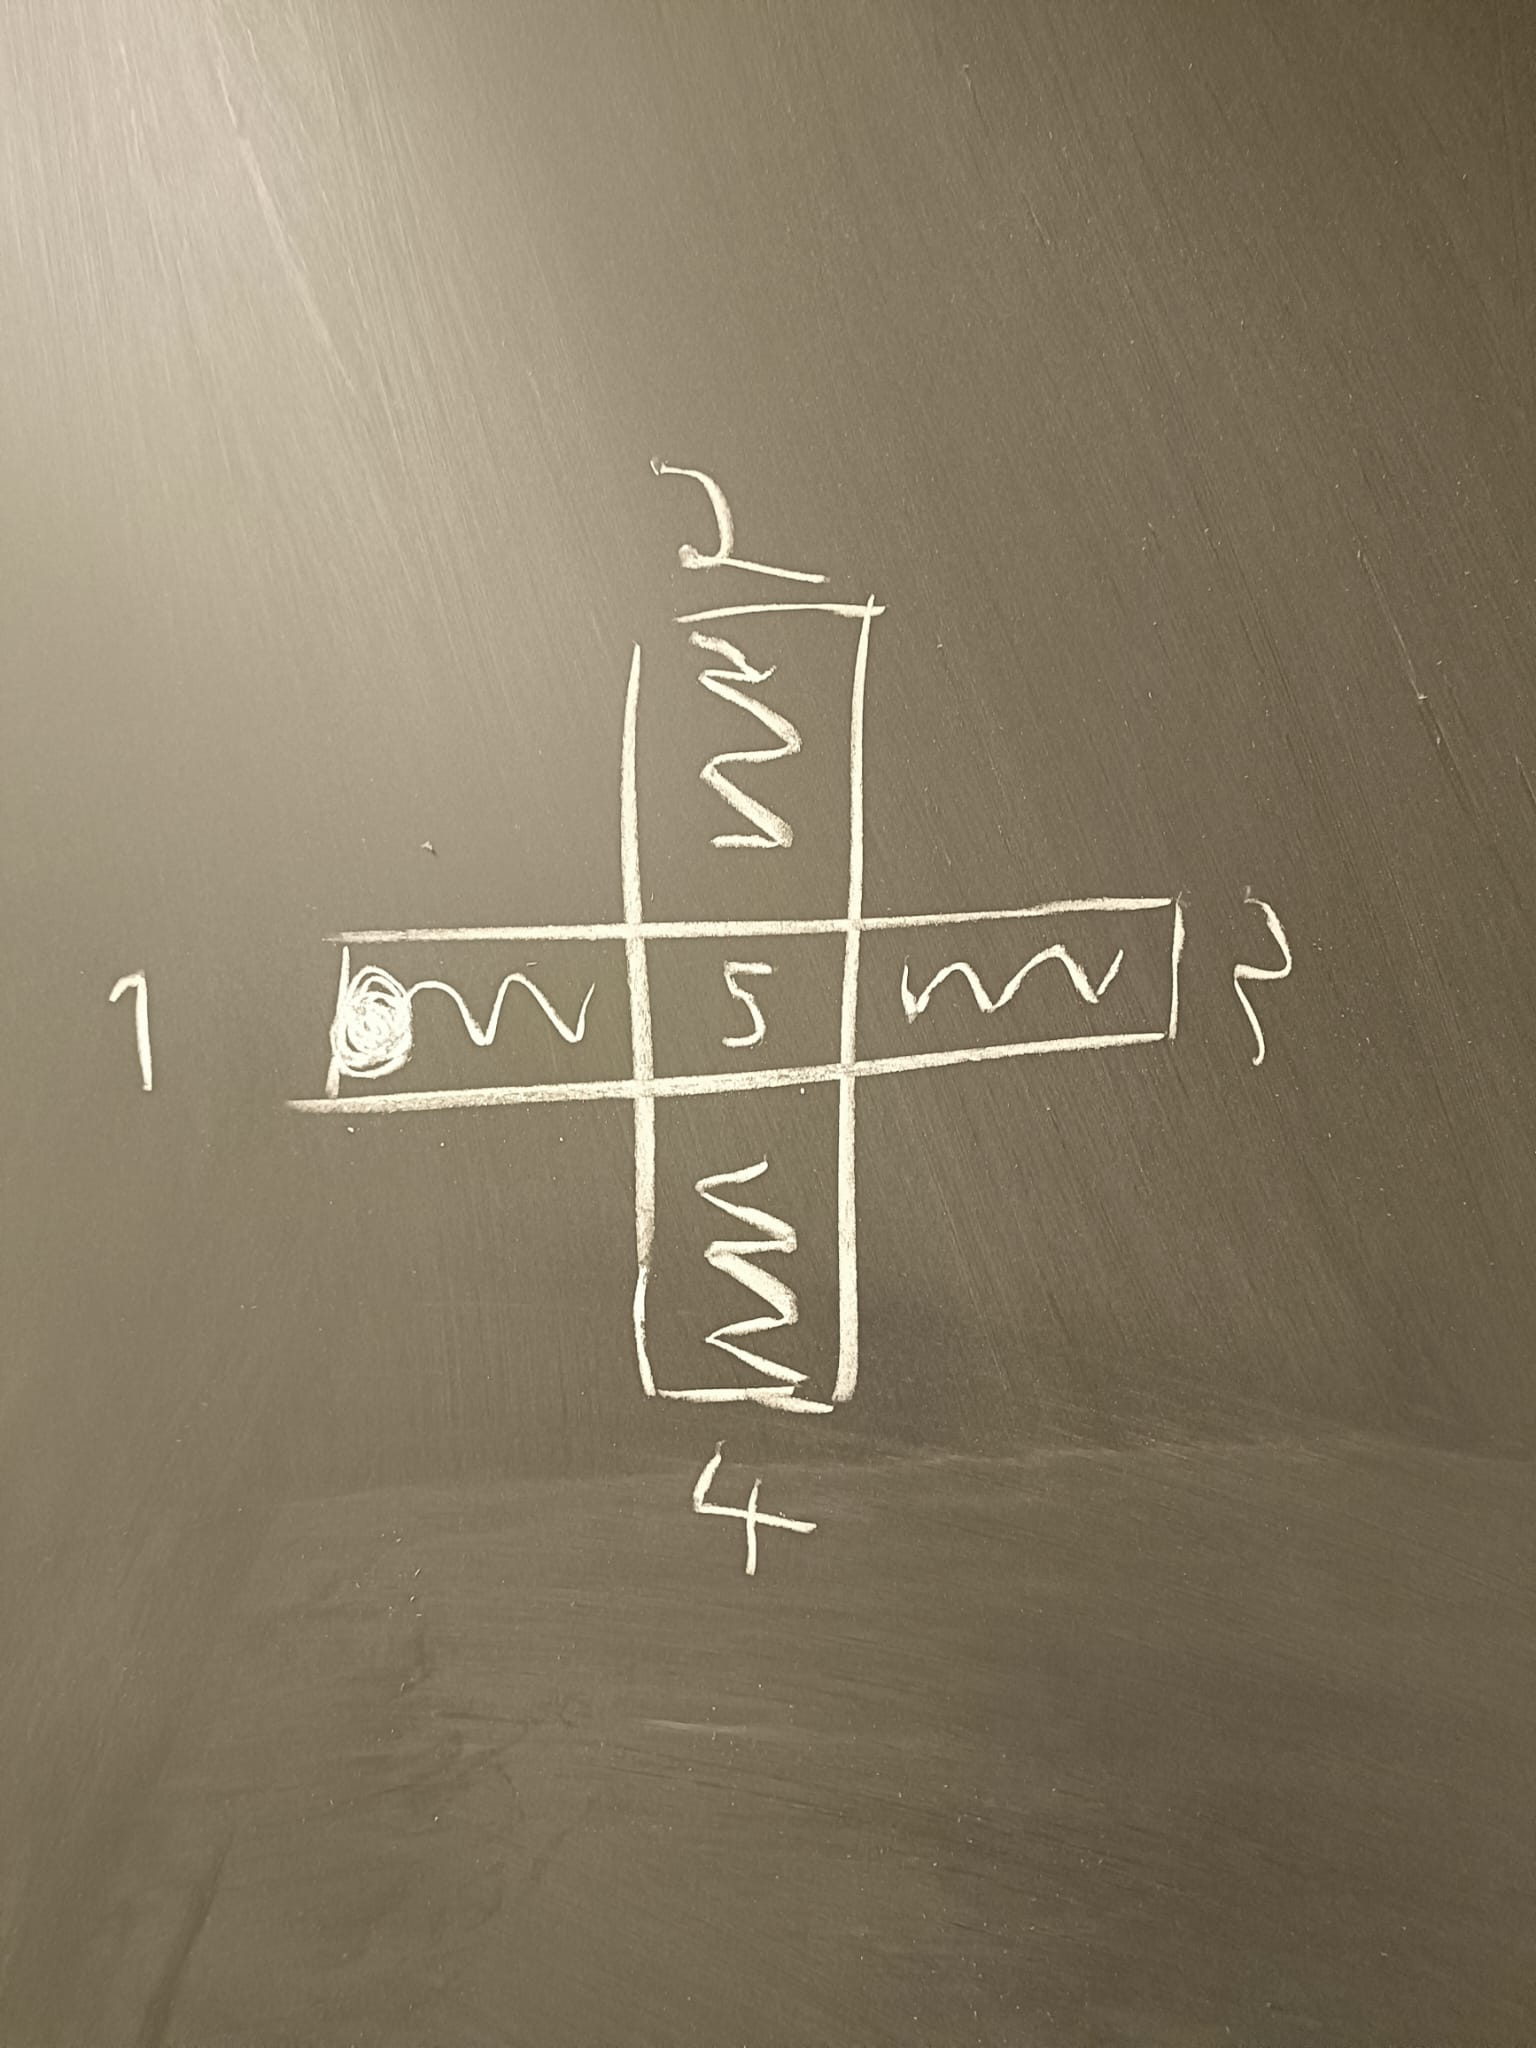
</div>

In [ ]:
## Not in use - keep just in case I can't recover from Git

In [ ]:
# # Build Incidence Matrices and vectors of edges

# EI, EJ, EIEJ_plots, DM, NE, NN = Matrixfuncs.build_incidence(Variabs)     
# Structure = Classes.Net_structure(EI, EJ, EIEJ_plots, DM, NE, NN)

In [ ]:
## Initiate K matrix

# K, K_mat = Matrixfuncs.initiateK(NE, K_max)

In [ ]:
## build network and plot structure

# NET = NETfuncs.buildNetwork(EIEJ_plots)
# pos_lattice = NETfuncs.plotNetStructure(NET, 'Cells')

In [ ]:
## Identify edges at connections of cells and at boundaries for ease of use

# NConncetions = int(NGrid*(NGrid-1)*2)
# EdgesConnections = [int(i) for i in range(NE-NConncetions, NE)]

# NBoundaries = NGrid*4
# left_side = [0 + 4*NGrid*i for i in range(NGrid)]
# bottom_side = [1 + 4*i for i in range(NGrid)]
# right_side = [2 + 4*(NGrid-1) + 4*NGrid*i for i in range(NGrid)]
# top_side = [4*NGrid*(NGrid-1) + 3 + 4*i for i in range(NGrid)]
# EdgesBounaries = np.append(left_side, np.append(bottom_side, np.append(right_side, top_side)))
# # EdgesBounaries = np.array([], int)
# EdgesTotal = np.append(EdgesConnections, EdgesBounaries)

In [ ]:
## Set up constraints for whole loop

# NodeData_full = array([[input_p], [input_p]])  # input p value
# # Nodes_full = array([[6], [35]])  # input p node
# Nodes_full = array([[input_output_pairs[i, 0]] for i in range(len(input_output_pairs))])  # input p node


# GroundNodes_full = array([[input_output_pairs[i, 1]] for i in range(len(input_output_pairs))])  # nodes with zero pressure
# GroundNodes_full_Allostery = array([GroundNodes_full[i][0] for i in range(len(GroundNodes_full))])

# EdgeData_full = array([[0], [0]])  # pressure drop value on edge

# # Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                     EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# # Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
# #                               EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) 
# #                                          & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                     EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
#                               EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
#                                          & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

# # Edges_full = array([EdgesConnections, EdgesConnections])
# # output_edges = [np.where(np.append(EI, EJ)==GroundNodes_full[i])[0][0] % len(EI) for i in range(len(GroundNodes_full))]
# output_edges = np.array([np.where(np.append(EI, EJ)==GroundNodes_full[i])[0] % len(EI) 
#                          for i in range(len(GroundNodes_full))])

In [ ]:
## Solve flow with no marbles, i.e. uniform high conductance, for normalization of flow

# u_final_noCond = zeros([2, 2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full[i]
#     GroundNodes = array([GroundNodes_full[0][0], GroundNodes_full[1][0]])
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
        
#     # u_final_noCond[i,:] = u[output_edges]
#     u_final_noCond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]

In [ ]:
# def flow_iterate(iterations, NodeData, Nodes, EdgeData, Edges, GroundNodes, output_edges, DM, K_mat, NN, EI, EJ, flow_scheme, 
#                  sim_type='w marbles', plot='yes'):
    
#     u_final = zeros([2, 2])
#     u_all = np.zeros([NE, iterations])

#     for i in range(iterations):
#         m = i % 2

#         # this is the normal direction of flow

#         NodeData = NodeData_full[m] 
#         Nodes = Nodes_full[m] 
#         EdgeData = EdgeData_full[m]
#         Edges = Edges_full[m]
#         GroundNodes = GroundNodes_full[m]

#         # switch ground and input nodes every 2nd iteration 
#         if i % 4 > 1 and flow_scheme == 'taktak':
#             Nodes = GroundNodes_full[m] 
#             GroundNodes = Nodes_full[m]

#         # As matrix
#         Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  

#         for l in range(3):

#             L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#             p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)

#             # correct for very low velocities
#             u[abs(u)<10**-10] = 0 
            
#             if sim_type == 'w marbles':
#                 K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#                 K_mat = np.eye(NE) * K_nxt
#                 K = copy.copy(K_nxt) 
        
#         if sim_type == 'Allostery test' or sim_type == 'no marbles':
#             u_final[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]
#         else:
#             # p_all[:, i] = p
#             u_all[:, i] = u

#         if plot == 'yes':
#             NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
#     return u_final, u_all, K_mat

In [ ]:
## Loop while changing conductivities

# u_all = np.zeros([NE, iterations])
# for i in range(iterations):
#     m = i % 2
    
#     # this is the normal direction of flow
    
#     NodeData = NodeData_full[m] 
#     Nodes = Nodes_full[m] 
#     EdgeData = EdgeData_full[m]
#     Edges = Edges_full[m]
#     GroundNodes = GroundNodes_full[m]
    
#     # switch ground and input nodes every 2nd iteration 
#     if i % 4 > 1 and flow_scheme == 'taktak':
#         Nodes = GroundNodes_full[m] 
#         GroundNodes = Nodes_full[m]
    
#     # As matrix
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  
    
#     for l in range(3):

#         L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#         p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
        
#         # correct for very low velocities
#         u[abs(u)<10**-10] = 0

#         # NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#         K_nxt = Matrixfuncs.ChangeKFromFlow(u, u_thresh, K, K_max, K_min, NGrid)
#         K_mat = np.eye(NE) * K_nxt
#         K = copy.copy(K_nxt)  
    
#     # p_all[:, i] = p
#     u_all[:, i] = u

In [ ]:
## Allostery Check

# u_final_cond = zeros([2,2])

# for i in range(2):
#     NodeData = NodeData_full[i] 
#     Nodes = Nodes_full[i] 
#     EdgeData = EdgeData_full[i]
#     Edges = Edges_full_Allostery[i]
#     GroundNodes = GroundNodes_full_Allostery
    
#     Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

#     L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

#     p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
#     # correct for very low velocities
#     u[abs(u)<10**-10] = 0

#     NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

#     # u_final_cond[i,:] = u[output_edges]
#     u_final_cond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]